# Welcome the the Golf Predictor! 🏌
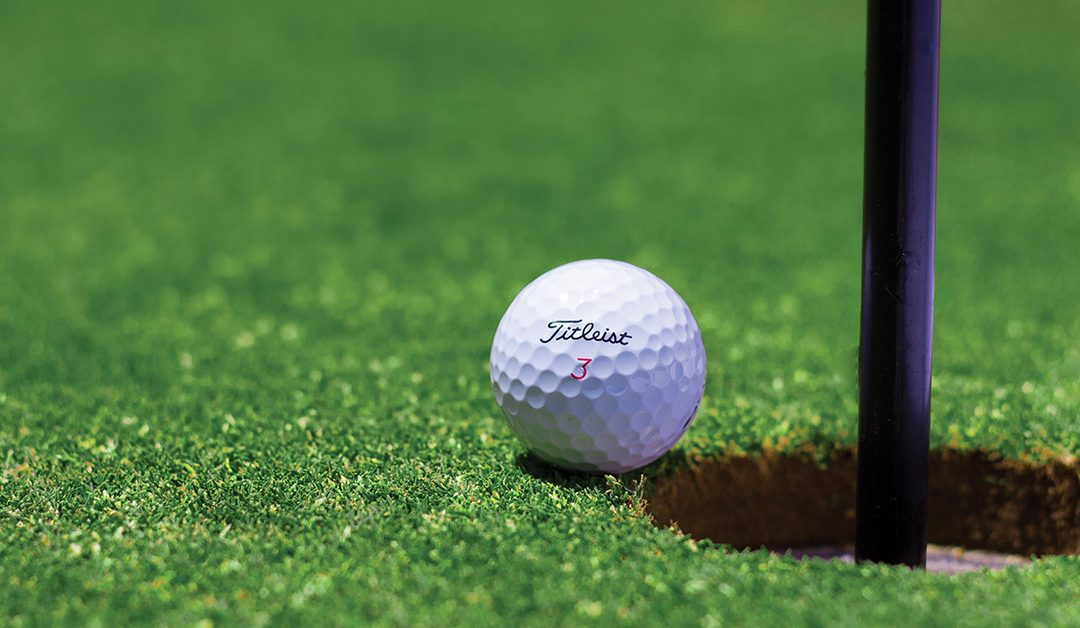

---


**Video Walkthrough:**  https://youtu.be/KwKQHAUoarQ



**Github Link:** https://github.com/jackherberger/Golf_Predictor

**Here is a high level overview of our project:**

**Our big question**
* Can we accurately predict the winner of an upcoming tournament? Can we see how much money we would have won if we used our model to place bets on winner, top 5 and top 10 finishers?

**Storage**:
* The data is stored in a downloadable CSV file that we transfered to Github so it can be accessed directly from a link. It was accessed from Kaggle.com

* We will use almost all of the elements from the CSV file that pertain to how a player played on a course and certain factors such as which tournament and weather, but will omit irrelevant data such as unnamed columns.


**Cleaning**
* The first dataset is very complete however it will need to be modified to fit the regression model such as using dummies for categorical variables and shaving off extreme outliers. Otherwise, the dataset is in a good format, as it is in a csv file that is comma separated.


**Integration**
* We have multiple sources of data, so we will need to integrate the data. In order to do this, we plan to match the player/date/tournaments so that we can have all of the data from a given match.
* In order to match find difficulty, we will have to match the player data set to the course dataset and evaluate based on given factors


**Analysis**
* With the data, we plan to set up a regression model that can use the data we have to make a prediction about who will win upcoming tournaments, and see if its a good model to use to betting predictions.


**Communication**
We will communicate our findings with pandas DataFrames and Matplotlib to plot our data findings


# Let's get our necessary imports...

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from math import sqrt

# Nice, now, lets get our data ready
1.) Import csv datasets

In [ ]:
player_data = "https://raw.githubusercontent.com/jackherberger/FairwayForecast/main/ASA%20All%20PGA%20Raw%20Data%20-%20Tourn%20Level.csv"
df_players = pd.read_csv(player_data)

https://github.com/jackherberger/Golf_Predictor/blob/main/dg_course_table-1.csv

course_data = "https://raw.githubusercontent.com/jackherberger/FairwayForecast/main/dg_course_table.csv"
df_courses = pd.read_csv(course_data)


In [ ]:
df_courses.course = df_courses.course.str.upper()
df_players.course = df_players.course.str.upper()

Let's clean up our course names for the players table

In [ ]:
df_players.course = df_players.course.str.split('-', n=1).str[0].str.strip()

Set our indices

In [ ]:
df_courses = df_courses.set_index('course')
df_players = df_players.set_index('player id')

Let's drop the unnecesary columns

In [ ]:
df_players = df_players.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
df_players = df_players.replace('Nan', np.nan)
df_players = df_players.dropna(axis=0)
df_players = df_players.sort_index()
df_players = df_players[df_players.course.isin(df_courses.index)]

Create our merged DF

In [ ]:
df_merged = pd.merge(df_players, df_courses, left_on='course', right_index=True)

# Nice, lets look at our data...

In [ ]:
df_players.iloc[1]

Player_initial_last                R. Allenby
tournament id                            2250
hole_par                                  280
strokes                                   284
hole_DKP                                 48.5
hole_FDP                                 42.0
hole_SDP                                   56
streak_DKP                                  0
streak_FDP                                6.2
streak_SDP                                  0
n_rounds                                    4
made_cut                                    1
pos                                      64.0
finish_DKP                                  0
finish_FDP                                  0
finish_SDP                                  0
total_DKP                                48.5
total_FDP                                48.2
total_SDP                                  56
player                         Robert Allenby
tournament name        FedEx St. Jude Classic
course                          TP

In [ ]:
df_courses.head()

,par,yardage,yardage_4_5,yardage_3,adj_score_to_par,adj_par_3_score,adj_par_4_score,adj_par_5_score,adj_driving_distance,adj_sd_distance,adj_driving_accuracy,putt_sg,arg_sg,app_sg,ott_sg
course,,,,,,,,,,,,,,,
OCEAN COURSE AT KIAWAH ISLAND,72,7671,489,207,2.57,0.29,0.21,-0.17,293.0,17.9,0.5894,-0.005,-0.020,-0.056,-0.017
TORREY PINES SOUTH (U.S. OPEN),71,7635,490,194,2.57,0.18,0.20,-0.12,300.8,17.8,0.4870,-0.014,-0.020,-0.027,-0.003
TORREY PINES GOLF COURSE (SOUTH COURSE),72,7584,486,194,1.13,0.09,0.17,-0.24,288.9,15.6,0.5310,-0.020,0.007,0.003,-0.027
QUAIL HOLLOW CLUB (PGA CHAMPIONSHIP),71,7488,476,208,2.84,0.23,0.25,-0.26,290.5,19.1,0.5788,-0.017,-0.052,-0.013,0.013
CROOKED STICK GC,72,7474,478,195,-0.32,0.13,0.07,-0.38,284.2,16.1,0.6167,0.007,0.002,0.022,-0.006


In [ ]:
df_merged.head()

,Player_initial_last,tournament id,hole_par,strokes,hole_DKP,hole_FDP,hole_SDP,streak_DKP,streak_FDP,streak_SDP,...,adj_par_3_score,adj_par_4_score,adj_par_5_score,adj_driving_distance,adj_sd_distance,adj_driving_accuracy,putt_sg,arg_sg,app_sg,ott_sg
player id,,,,,,,,,,,,,,,,,,,,,
5,R. Allenby,2242,284,282,58.5,52.3,65,0,5.2,0,...,0.12,0.04,-0.33,275.1,19.4,0.614,-0.003,0.044,-0.028,-0.056
16,A. Baddeley,401025246,284,284,66.0,54.0,60,0,12.4,0,...,0.12,0.04,-0.33,275.1,19.4,0.614,-0.003,0.044,-0.028,-0.056
16,A. Baddeley,2494,284,281,62.0,56.5,64,3,16.2,4,...,0.12,0.04,-0.33,275.1,19.4,0.614,-0.003,0.044,-0.028,-0.056
16,A. Baddeley,2242,284,285,62.0,51.6,59,0,12.6,0,...,0.12,0.04,-0.33,275.1,19.4,0.614,-0.003,0.044,-0.028,-0.056
68,C. Campbell,2701,284,280,61.0,57.4,66,3,7.4,3,...,0.12,0.04,-0.33,275.1,19.4,0.614,-0.003,0.044,-0.028,-0.056


# Let's look at how the holes you see affect you overall score

**Score-related Regression:**

**Dependent Variable:** `adj_score_to_par`

**Independent Variables:** `adj_par_3_score`, `adj_par_4_score`, `adj_par_5_score`

**Interpretation:** Analyze how different types of holes contribute to the overall score.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

features = ['adj_par_3_score', 'adj_par_4_score', 'adj_par_5_score']
target = 'adj_score_to_par'

X_train, X_test, y_train, y_test = train_test_split(df_courses[features], df_courses[target], test_size=0.2, random_state=42)

model = make_pipeline(
    ColumnTransformer(
        transformers=[('num', StandardScaler(), features)]
    ),
    LinearRegression()
)

model.fit(X_train, y_train)

y_ = model.predict(X_test)

mean_squared_error = mean_squared_error(y_test, y_)
print("Mean squared error: ", mean_squared_error)

r_squared_error = r2_score(y_test, y_)
print("R squared error: ", r_squared_error)



Mean squared error:  0.16175150874086275
R squared error:  0.909787720158738


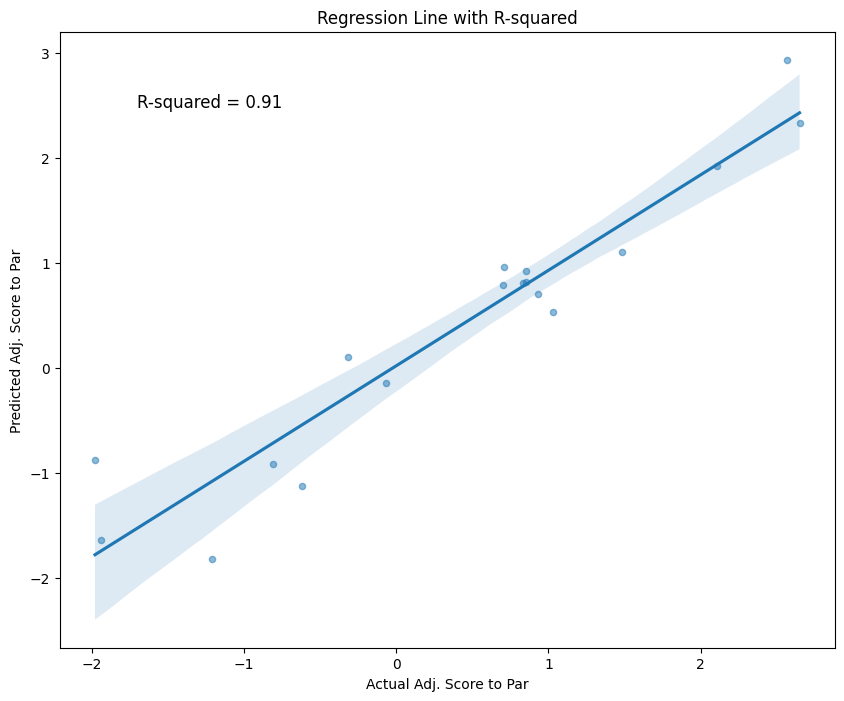

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 8))
sns.regplot(x=y_test, y=y_, scatter_kws={'s': 20, 'alpha': 0.5})
plt.title('Regression Line with R-squared')
plt.xlabel('Actual Adj. Score to Par')
plt.ylabel('Predicted Adj. Score to Par')

# Add the regression line equation
plt.text(0.1, 0.9, f'R-squared = {r_squared_error:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()

Wow, pretty linear...

We got a R^2 value of 0.909. This seems to show us that the features `adj_par_3_score`, `adj_par_4_score`, and `adj_par_5_score` are highly affective training variables when prediecting what your final score is.

**Hold on a second, what does this actually mean?**

Well we're saying that if you were to train a linear regression model on all the scores you get on par 3s, 4s, and 5s, it would be a good prediction for your overall score. Well, that seems pretty **obvious**. But still, good to know for our future predictions.



# Lets now look at how your performance around the greens affect your putting


This hopefully will tell us if a golfers performance on the shots leading up to the green affect their putting abilities. Which could potentially help us with our future predictions.

**Putting Performance Regression:**

**Dependent Variable:** `putt_sg`

**Independent Variables:** `arg_sg`, `app_sg`

Lets really quick talk about our variables here

* `putt_sg` is the number of strokes gained while putting
*   `arg_sg` is the number of strokes gained around the green
*   `app_sg` is the number of strokes gained on approach shots





In [ ]:
putting_features = ['arg_sg', 'app_sg', 'ott_sg']
target = 'putt_sg'

X_putt_train, X_putt_test, y_putt_train, y_putt_test = train_test_split(df_courses[putting_features], df_courses[target], test_size=0.2, random_state=42)

model = make_pipeline(
    ColumnTransformer(
        transformers = [('num', StandardScaler(), putting_features)]
    ),
    LinearRegression()
)

model.fit(X_putt_train, y_putt_train)

y_pred_putt = model.predict(X_putt_test)

putt_r2 = r2_score(y_putt_test, y_pred_putt)

print("R squared error: ", putt_r2)



R squared error:  -0.3274348108226883


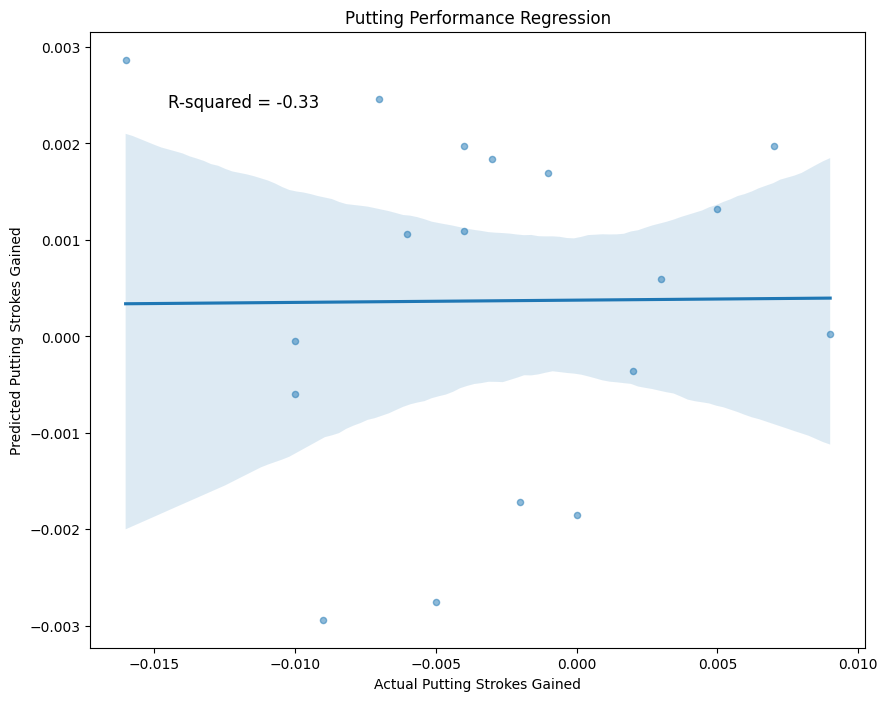

In [ ]:
plt.figure(figsize=(10, 8))
sns.regplot(x=y_putt_test, y=y_pred_putt, scatter_kws={'s': 20, 'alpha': 0.5})
plt.title('Putting Performance Regression')
plt.xlabel('Actual Putting Strokes Gained')
plt.ylabel('Predicted Putting Strokes Gained')

# Add the regression line equation and R-squared value
plt.text(0.1, 0.9, f'R-squared = {putt_r2:.2f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.show()

Hmm, interesting...
It seems as though are model is **worse** thart a simple horizontal line representing the mean. Let's play around with this, here are some things we could try:


*   Changing to a KNeighbors
*   Changing our scaler to a polynomial feautures, maybe its non linear?




# How can we use the course to analyze performance?

Here we are going to combine our dataframes using merge from pandas to get course data for each instance of a player completing a round. Now for each player, we can analyize both their stats and the course they played on to get a better prediction of how they played.

* From the player data, we took `n_rounds`, `purse`, `total_DKP`, and `total_FDP`

* From the course data, we took `par`, `yardage`, `putt_sg`, `arg_sg`, `app_sg`, `ott_sg`

Using these values from the dataframe, we are able to create a regression model that pricts `strokes`, the varaible holding the stroke count of a player in the respective tournament

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


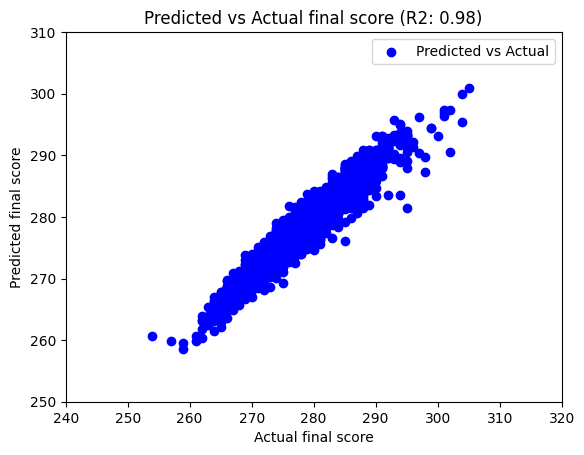

In [ ]:
X = df_merged[['n_rounds', 'purse', 'total_DKP', 'total_FDP',
               'par', 'yardage', 'putt_sg', 'arg_sg', 'app_sg', 'ott_sg']]
y = df_merged[['strokes']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

scaler = StandardScaler(with_mean=False)

model = VotingRegressor([
    ("linear", LinearRegression()),
    ("knn", KNeighborsRegressor(5))
])

pipeline = make_pipeline(scaler, model)
pipeline.fit(X_train, y_train)
y_ = pipeline.predict(X_test)
r2 = r2_score(y_test, y_)

plt.scatter(y_test, y_, color='blue', label='Predicted vs Actual')
plt.xlabel('Actual final score')
plt.ylabel('Predicted final score')
plt.title(f'Predicted vs Actual final score (R2: {r2:.2f})')
plt.legend()
plt.gca().set_xlim([240, 320])
plt.gca().set_ylim([250, 310])
plt.show()

# Incredible!

The model gave us a r2 score of 0.98. This shows us that combining the course and the player data is essential to making a good prediction, and in doing so our model is extremely accurate.

# Now, lets try to predict the outcome of a big upcoming match, **The Masters**

**The Masters** is one of the 4 most sought after tournaments in the PGA season, and it happens soon, April 11th. Players come into this tournament ready to go head to head, to fight for everything to get that green jacket. So lets try to predict who will win based off player perfomance at the home course of the masters, **Augusta National Golf Club**.

First thing we need to do is restrict our dataset to rounds played at the specific course, **Augusta National Golf Club**.

In [ ]:
df_augusta = df_merged[df_merged['course'] == 'AUGUSTA NATIONAL GOLF CLUB']

Awesome, now we have our combined dataset, with all players who have played rounds at Augusta National, the home course of The Masters. Lets see if we can use this to predict the outcomes of the upcoming tournament.

In [ ]:
X = df_augusta[['n_rounds', 'purse', 'total_DKP', 'total_FDP',
               'par', 'yardage', 'putt_sg', 'arg_sg', 'app_sg', 'ott_sg']]
y = df_augusta[['strokes']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)
scaler = StandardScaler(with_mean=False)

linear_model = LinearRegression()
knn_model = KNeighborsRegressor(5)


stacking_model = StackingRegressor([
    ("linear", linear_model),
    ("knn", knn_model)],
    final_estimator=LinearRegression()
)
stacking_model.fit(X=X_train, y=y_train)
y_ = stacking_model.predict(X_test)

r2 = r2_score(y_test, y_)

print("\n R2 score: ", r2)
print("\n\n\n\n")



 R2 score:  0.8090726633163088







/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_stacking.py:957: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Pretty good, but let's see if a Voting Regressor is better...

In [ ]:
X = df_augusta[['n_rounds', 'purse', 'total_DKP', 'total_FDP',
               'par', 'yardage', 'putt_sg', 'arg_sg', 'app_sg', 'ott_sg']]
y = df_augusta[['strokes']]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

scaler = StandardScaler(with_mean=False)

model = VotingRegressor([
    ("linear", LinearRegression()),
    ("knn", KNeighborsRegressor(5))
])

pipeline = make_pipeline(scaler, model)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

X_test_with_predictions = X_test.copy()
X_test_with_predictions['predicted_strokes'] = np.floor(y_pred).astype(int)

X_test_with_predictions['player_name'] = df_augusta.loc[X_test.index, 'player']

ranked_players = X_test_with_predictions.sort_values(by='predicted_strokes')

y_ = pipeline.predict(X_test)
r2 = r2_score(y_test, y_)

print("\n R2 score: ", r2)
print('\n\n\n\n')


 R2 score:  0.8549411258519286







/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Looking good, now let's predict our actual rankings, calculated based on predicted strokes.

In [ ]:
actual = df_augusta.sort_values(by='strokes')

final = actual[actual['player'].isin(ranked_players['player_name'])]

final_df = pd.merge(final, ranked_players[['predicted_strokes']], on='player id', how='inner')
final_df['difference'] = final_df['strokes'] - final_df['predicted_strokes']

print(final_df[['player', 'strokes', 'predicted_strokes', 'difference']])
score = (final['strokes'] - ranked_players['predicted_strokes'])

score.mean()

                        player  strokes  predicted_strokes  difference
player id                                                             
9478         Scottie Scheffler      278                280          -2
11098            Cameron Champ      288                289          -1
9513               Talor Gooch      290                293          -3
455               Lee Westwood      290                290           0
9037       Matthew Fitzpatrick      290                293          -3
5539           Tommy Fleetwood      290                290           0
10166               J.J. Spaun      291                292          -1
6991         Harold Varner III      291                289           2
4364873         Viktor Hovland      292                290           2
8961               Sepp Straka      293                292           1
7081                Si Woo Kim      295                294           1
6086                  Tom Hoge      295                295           0
388   

-0.07692307692307693

In [ ]:
squared_error = (final['strokes'] - ranked_players['predicted_strokes']) ** 2

mse = np.mean(squared_error)
print(sqrt(mse))

1.8187062180825984


This is telling us that our model was an average just 1.8 strokes off. In the grand scheme of things, in a tournament golfers usually have over 300 strokes, so this is pretty good!

# Let's do some web scraping!

Before we begin, let's do our due diligence... https://dknetwork.draftkings.com/robots.txt allows user scraping of the pages we want.



The [URL](https://dknetwork.draftkings.com/2022/4/3/23005350/masters-odds-2022-favorites-sleepers-pga-tour-jon-rahm-tiger-woods-scottie-scheffler-dustin-johnson) below holds a table all of the odds for the 2022 masters that Draft King betting lines for each player. We are going to scrape this site to grab all this data, then we can calculate how much our model would have won if:


1.   You bet $100 on our predicted winner

2.   You bet $20 on each of our predicted top 5 finishers

3.   You bet $10 on each of our predicted top 10 finishers




In [ ]:
import requests
from bs4 import BeautifulSoup


url = "https://dknetwork.draftkings.com/2022/4/3/23005350/masters-odds-2022-favorites-sleepers-pga-tour-jon-rahm-tiger-woods-scottie-scheffler-dustin-johnson"
headers = {
      "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36"
   }

response = requests.get(url, headers=headers)

if response.status_code != 200 or response.history:
  print(f"Failed to access {url}")

soup = BeautifulSoup(response.text, 'html.parser')
soup

table_rows = soup.find_all('tr')
df_odds = []

for row in table_rows:
  inner_rows = row.find_all('td')
  if len(inner_rows) >= 4:
    name = inner_rows[0].text
    win = inner_rows[1].text
    top_5 = inner_rows[2].text
    top_10 = inner_rows[3].text
    df_odds.append([name, win, top_5, top_10])

df_odds = pd.DataFrame(df_odds, columns=['Name', 'Win_Odds', 'Top_5_Odds', 'Top_10_Odds'])
df_odds.set_index('Name', inplace=True)
df_odds


,Win_Odds,Top_5_Odds,Top_10_Odds
Name,,,
Jon Rahm,+850,+200,+100
Scottie Scheffler,+1200,+300,+140
Cameron Smith,+1400,+330,+150
Justin Thomas,+1400,+330,+150
Dustin Johnson,+1600,+350,+170
...,...,...,...
Sandy Lyle,+100000,+30000,+20000
Mike Weir,+100000,+30000,+20000
Bernhard Langer,+100000,+8000,+2500


So we have our odds ready to go. Now, instead of splitting up our testing and training data, we want to predict for all of our players we have in our dataset, not just the players in our test data.

In [ ]:
X = df_augusta[['n_rounds', 'purse', 'streak_DKP', 'streak_FDP',
               'par', 'yardage', 'putt_sg', 'arg_sg', 'app_sg', 'ott_sg']]
y = df_augusta[['strokes']]

scaler = StandardScaler(with_mean=False)

model = VotingRegressor([
    ("linear", LinearRegression()),
    ("knn", KNeighborsRegressor(5))
])

pipeline = make_pipeline(scaler, model)

pipeline.fit(X, y)

y_pred = pipeline.predict(X)

X_test_with_predictions = X.copy()
X_test_with_predictions['predicted_strokes'] = np.floor(y_pred).astype(int)

X_test_with_predictions['player_name'] = df_augusta.loc[X.index, 'player']

ranked_players = X_test_with_predictions.sort_values(by='predicted_strokes')

y_ = pipeline.predict(X)
r2 = r2_score(y, y_)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_voting.py:597: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Now that we have our predictions, we want to get our actual winners from our df_augusta DataFrame, that had the actual stroke numbers for each player. We can rank based on that to see who actually won in 2022.

In [ ]:
df_a = df_augusta.sort_values(by='strokes')

d = df_a['player']

topa = d.iloc[0]
top5a = d.iloc[:5]
top10a = d.iloc[:10]

actual_top = []
actual_top5 = []
actual_top10 = []
for i in range(10):
  if i <= 0:
    actual_top.append(d.iloc[i])
    actual_top5.append(d.iloc[i])
    actual_top10.append(d.iloc[i])
  elif i < 5:
    actual_top5.append(d.iloc[i])
    actual_top10.append(d.iloc[i])
  else:
    actual_top10.append(d.iloc[i])
print("Actual rankings:")
print("First place: ", actual_top[0])
print("Top 5: ", actual_top5)
print("Top 10: ", actual_top10)

Actual rankings:
First place:  Scottie Scheffler
Top 5:  ['Scottie Scheffler', 'Cameron Smith', 'Shane Lowry', 'Collin Morikawa', 'Will Zalatoris']
Top 10:  ['Scottie Scheffler', 'Cameron Smith', 'Shane Lowry', 'Collin Morikawa', 'Will Zalatoris', 'Corey Conners', 'Justin Thomas', 'Sungjae Im', 'Cameron Champ', 'Charl Schwartzel']


Nice, above we have our actual winners, now lets get our rankings for what our model predicted.

In [ ]:
'''
100 dollars on winner
20 dollars on each top 5
10 dollars on each top 10
'''

predicted_winner = ranked_players.iloc[0]['player_name']
predicted_top5 = ranked_players.iloc[:5]['player_name']
predicted_top10 = ranked_players.iloc[:10]['player_name']


print("Predicted rankings: \n")
print("First place: ", predicted_winner)
print("\nTop 5: ", predicted_top5)
print("\nTop 10: ", predicted_top10)


Predicted rankings: 

First place:  Cameron Smith

Top 5:  player id
9131        Cameron Smith
9478    Scottie Scheffler
4848        Justin Thomas
318              Kevin Na
5409       Russell Henley
Name: player_name, dtype: object

Top 10:  player id
9131           Cameron Smith
9478       Scottie Scheffler
4848           Justin Thomas
318                 Kevin Na
5409          Russell Henley
9877          Will Zalatoris
4587             Shane Lowry
6991       Harold Varner III
11382             Sungjae Im
4364873       Viktor Hovland
Name: player_name, dtype: object


# Calculating our winnings.

Let's review how betting odds work again.

When odds have a `+` sign in front of them, that means they are not favored to win. In golf, there are so many players and it is so volatile, that every player has very high payouts for predicting the 1st place winner. For example, Scottie Scheffler, who is the world number 1, is still +1200 to win the whole thing.

These odds tell you how much you will win for every $100 wager you put on.

For a simpler rule that we will use to calculate the payouts, each odd divided by 100 gives you the fractional odds. So, a +300 signifies 3/1 payout.




---


Let's look at if we put $100 on who we predicted to win, Cameron Smith.

As a note, Scottie Scheffler won, and we predicted him as our 2nd place winner.

In [ ]:
# We predicted Cam Smith to win, so we can predict how much he would have won, however,
# he came in second, so we lost $100.

winner_odds = df_odds.loc[predicted_winner]
if predicted_winner == actual_top[0]:

  potential_winner_prediction = int(winner_odds[0][1:]) + 100
  print("$", potential_winner_prediction)
else:
  print("We didn't get it right! We lost $100")


We didn't get it right! We lost $100




---


Now, lets look at how much we would have won if we put $20 on each of the top 5 players we predicted.

In [ ]:
# Heres how much you would have won if you put 20 dollars on each of the top 5 players we predicted:
total = 0

for i in range(len(predicted_top5)):
  if predicted_top5.iloc[i] in actual_top5:
    odds = df_odds.loc[predicted_top5.iloc[i]]
    total += (int(odds['Top_5_Odds'][1:]) / 100) * 20
print("Would have won: $", total)


Would have won: $ 126.0




---
Now, lets look at how much we would have won if we put $10 on each of the top 10 players we predicted.


In [ ]:
# Heres how much you would have won if you put 10 dollars on each of the top 10 players we predicted:
total = 0
for i in range(len(predicted_top10)):
  if predicted_top10.iloc[i] in actual_top10:
    odds = df_odds.loc[predicted_top10.iloc[i]]
    total += (int(odds['Top_10_Odds'][1:]) / 100) * 10
print("Would have won: $", total)


Would have won: $ 164.0


Hey, not terrible. Please remember, always gamble responsibly!

And just for fun, let's pretend you looked at our model and saw that we predicted Scottie as 2nd place, but you had a gut feeling he was going to steal the number 1 spot.


In [ ]:
winner_odds = df_odds.loc[predicted_winner]

if predicted_top5.iloc[2] == actual_top[0]:
    potential_winner_prediction = int(winner_odds[0][1:]) + 100
print("Would have won: $", potential_winner_prediction, "!!!")

Would have won: $ 1500 !!!
